# REDES NUERONALES RECURRENTES

Son redes neuronales especiales para el procesamiento de secuencias de datos, tales como:
* señales temporales
* series temporales
* textos
* habla

Se emplean para:

* predecir valores futuros de señales / series temporales
* procesamiento de texto y habla para diversas funciones (traducción, interpretación, predicción de texto, generación de texto, titulado de imágenes, etc.)


## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para procesar predecir el valor futuro de un señal)

fuente: https://juansensio.com/dl-yt/rnn/time_series

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [24]:
n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
X_train.shape, y_train.shape


((7000, 50, 1), (7000, 10, 1))

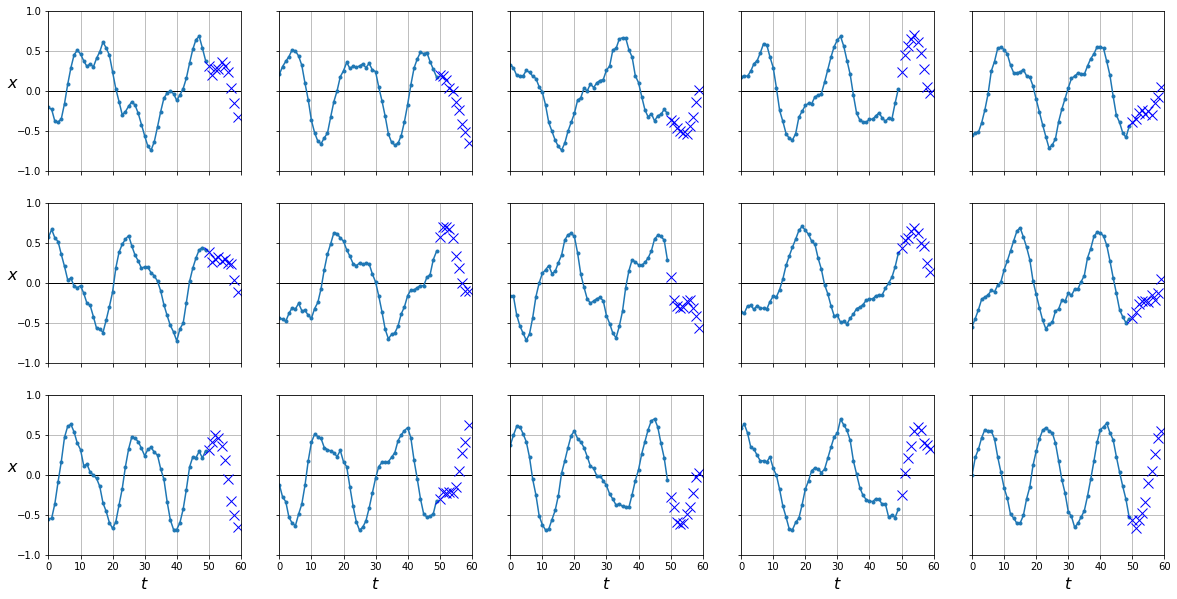

In [25]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

In [26]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [28]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

mlp = MLP()
mlp

MLP(
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [29]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [30]:
fit(mlp, dataloader)

loss 0.02586 val_loss 0.02470: 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


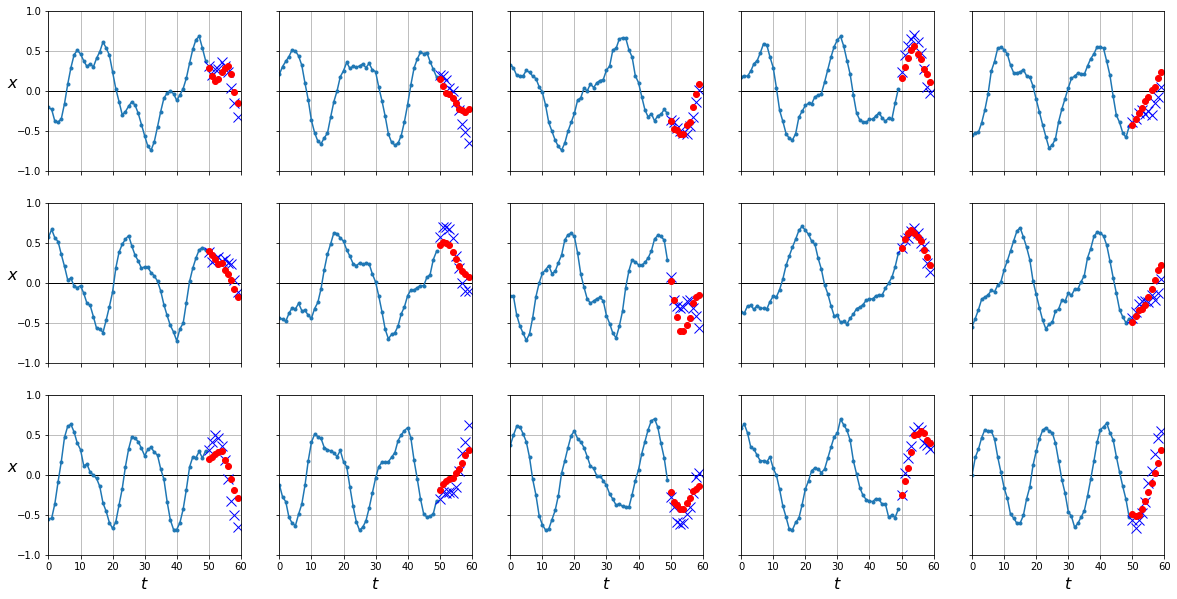

(1000, 10, 1)
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.025851622

In [31]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print(y_test.shape)
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

### Veamos ahora una RNN básica de 1 sola neurona

In [10]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salida
    return x[:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [11]:
fit(rnn, dataloader)

loss 0.14131 val_loss 0.13396: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


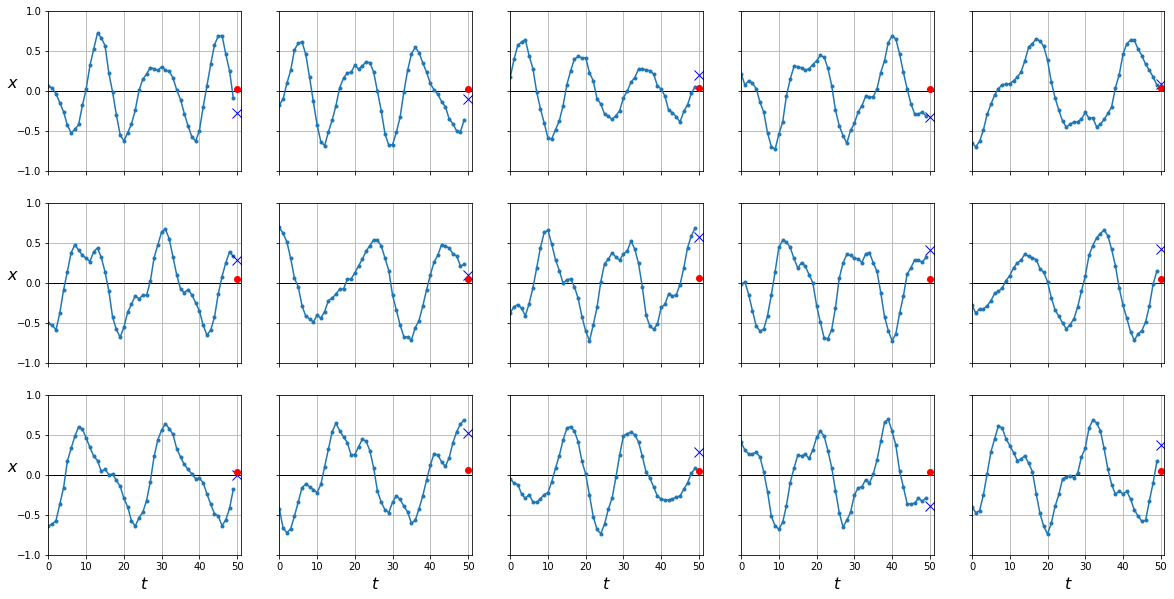

0.13312723

In [12]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

Comparacion de parámetros entre MLP y RNN implementada

In [13]:
# parámetros en el MLP

mlp.fc.weight.shape, mlp.fc.bias.shape

(torch.Size([1, 50]), torch.Size([1]))

In [14]:
# parámetros en la RNN simple

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape

(torch.Size([1, 1]), torch.Size([1, 1]), torch.Size([1]), torch.Size([1]))

Incorporamos más neuronas en la RNN

In [16]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [17]:
# parámetros en la nueva RNN 

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape, rnn.fc.weight.shape, rnn.fc.bias.shape

(torch.Size([20, 20]),
 torch.Size([20, 1]),
 torch.Size([20]),
 torch.Size([20]),
 torch.Size([1, 20]),
 torch.Size([1]))

In [18]:
fit(rnn, dataloader)

loss 0.00392 val_loss 0.00387: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


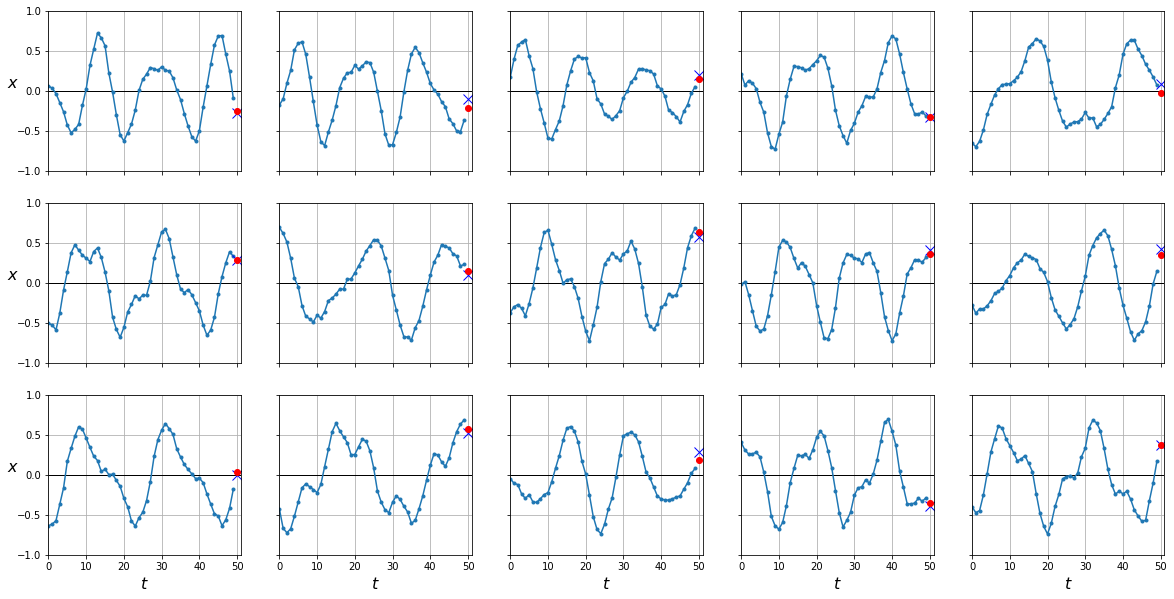

0.0035806466

In [19]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

Le agregamos 1 layer mas, para tenes mas profundidad

In [20]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [21]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.00361 val_loss 0.00357: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


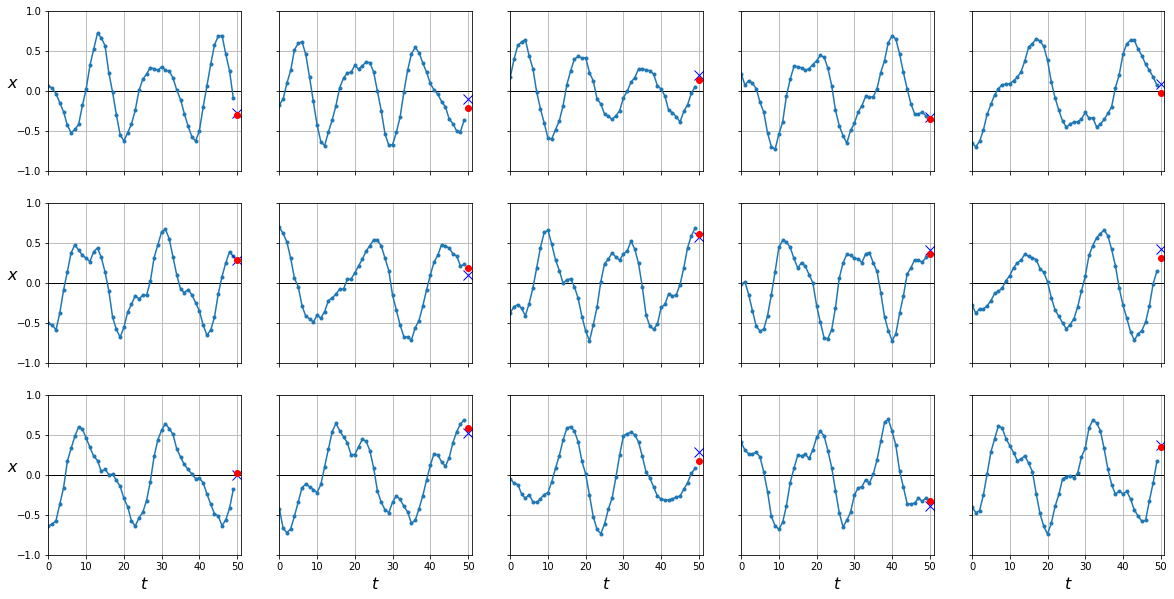

0.00347795

In [22]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

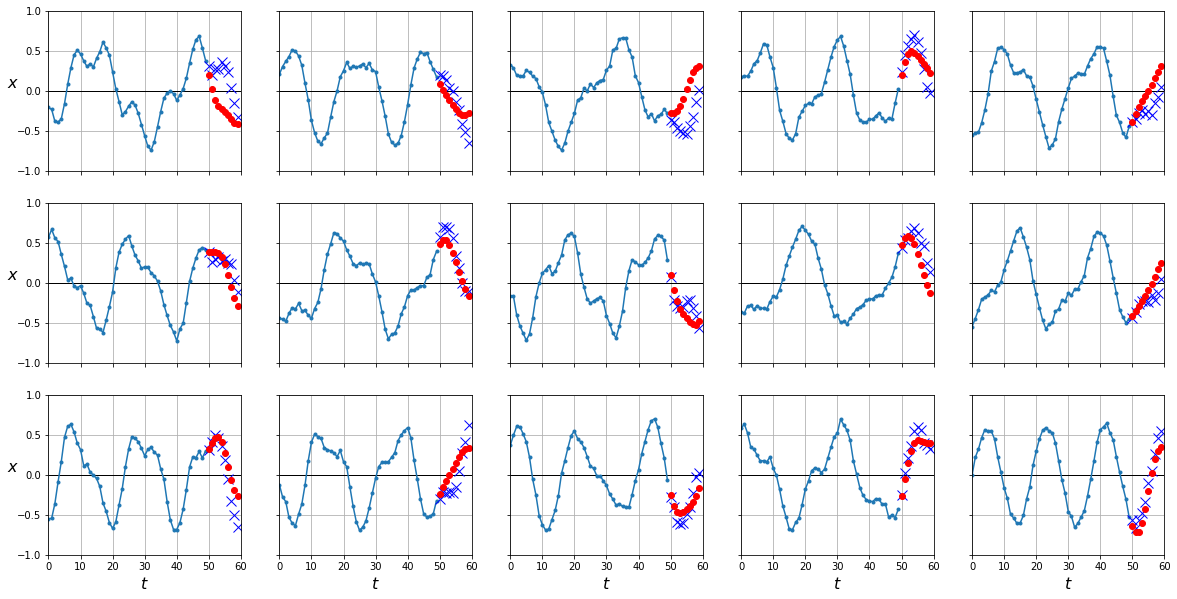

0.035423156

In [32]:
X = X_test
for step_ahead in range(n_future):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
mean_squared_error(np.squeeze(y_test), y_pred)

podemos tbn que la red saque 10 valores finales..., colocano n_out = 10

In [34]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [35]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.02846 val_loss 0.02800: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


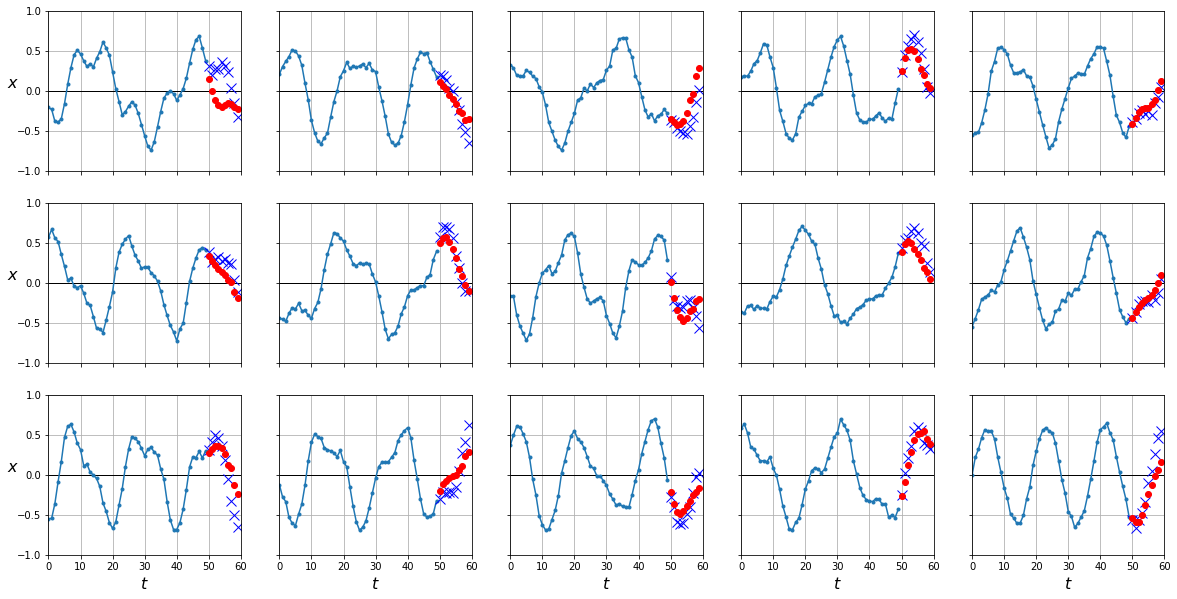

0.028004956

In [36]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

Como puede ver, nuestro error es mucho menor ya que hemos entrenado nuestra RNN a predecir 10 valores en cada instante temporal. Aún así, si observas atentamente la implementación, te darás cuenta que sólo optimizamos nuestra red con las salidas en el último instante. Esto significa que todavía podríamos mejorar más nuestro modelo si optimizamos para cada instante.





In [ ]:
n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

Desde el punto de vista de la implementación tenemos que tener en cuenta que nuestra capa fc solo conecta las neuronas de la capa oculta en el último paso con las salidas. Para poder optimizar para todos los instantes tenemos que colapsar las dimensiones del batch y los instantes temporales de la manera que puedes ver a continuación.

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

Como solo nos interesan los últimos 10 valores, calcularemos nuestra métricas solo para estos valores.


In [ ]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")
    

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.03416 loss_last_step 0.01983 val_loss 0.03345 val_loss_last_step 0.01854: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


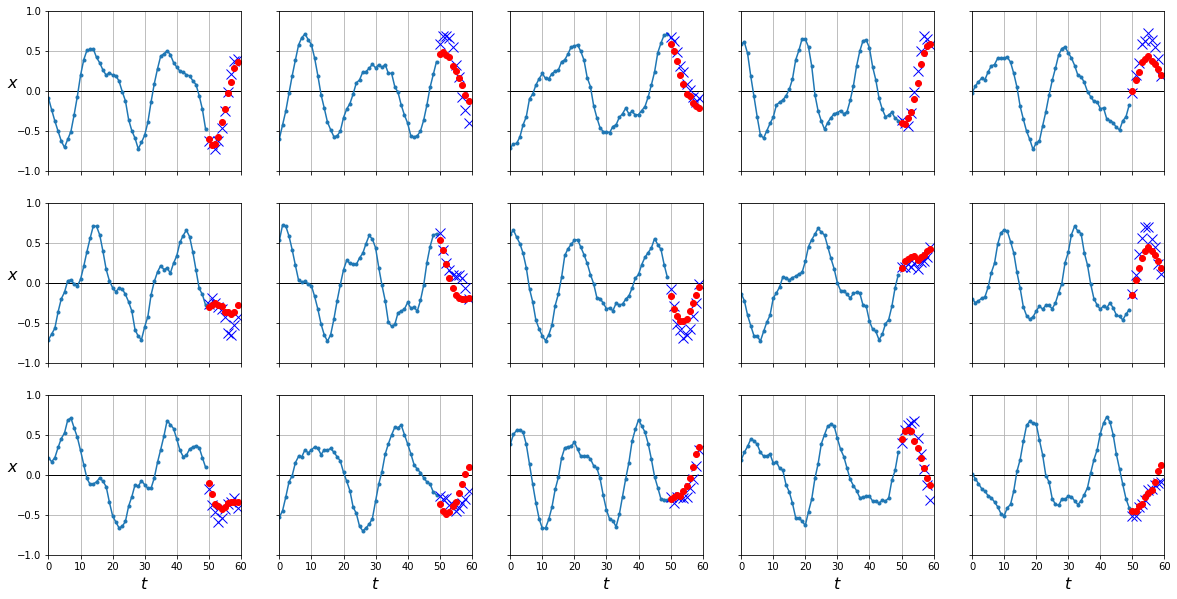

0.018080527

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

Optimizando para cada instante temporal tenemos muchos más gradientes fluyendo durante la etapa de backpropagation en vez de sólo desde la última salida (lo cual puede ser problemático ya que a las primeras iteraciones los gradientes que llegan pueden haber desaparecido).